<a href="https://colab.research.google.com/github/AlanTinajero/Computervisionmodel/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Constructing a Text Generation Model


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Using most of the techniques you've already learned, it's now possible to generate new text by predicting the next word that follows a given seed word. To practice this method, we'll use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics).

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2023-04-03 02:15:16--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.253.115.102, 172.253.115.100, 172.253.115.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.115.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uh67r4345itpvbe2cdvo2nahb2tv7lpo/1680488100000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=134a768a-6915-45e2-96d6-07189c3dbe47 [following]
--2023-04-03 02:15:18--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uh67r4345itpvbe2cdvo2nahb2tv7lpo/1680488100000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=134a768a-6915-45e2-96d6-07189c3dbe47
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.251.167.132, 2607:f8b0:4004:c1d::84
Connecting to d

## **First 10 Songs**

Let's first look at just 10 songs from the dataset, and see how things perform.

### Preprocessing

Let's perform some basic preprocessing to get rid of punctuation and make everything lowercase. We'll then split the lyrics up by line and tokenize the lyrics.

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:10]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'and': 3, 'a': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'ma': 10, 'it': 11, 'of': 12, 'im': 13, 'your': 14, 'love': 15, 'so': 16, 'as': 17, 'that': 18, 'in': 19, 'andante': 20, 'boomaboomerang': 21, 'make': 22, 'on': 23, 'oh': 24, 'for': 25, 'but': 26, 'new': 27, 'bang': 28, 'its': 29, 'be': 30, 'like': 31, 'know': 32, 'now': 33, 'how': 34, 'could': 35, 'youre': 36, 'sing': 37, 'never': 38, 'no': 39, 'chiquitita': 40, 'can': 41, 'we': 42, 'song': 43, 'had': 44, 'good': 45, 'youll': 46, 'she': 47, 'just': 48, 'girl': 49, 'again': 50, 'will': 51, 'take': 52, 'please': 53, 'let': 54, 'am': 55, 'eyes': 56, 'was': 57, 'always': 58, 'cassandra': 59, 'blue': 60, 'time': 61, 'dont': 62, 'were': 63, 'return': 64, 'once': 65, 'then': 66, 'sorry': 67, 'cryin': 68, 'over': 69, 'feel': 70, 'ever': 71, 'believe': 72, 'what': 73, 'do': 74, 'go': 75, 'all': 76, 'out': 77, 'think': 78, 'every': 79, 'leave': 80, 'look': 81, 'at': 82, 'way': 83, 'one': 84, 'music': 85, 'down': 

<ipython-input-3-fbdddccf8583>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-3-fbdddccf8583>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-3-fbdddccf8583>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.lower()


### Create Sequences and Labels

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with `texts_to_sequences`, but also including the use of [N-Grams](https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9); creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

32
97
[  0   0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29
   4]
[  0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29   4
 287]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Train a Text Generation Model

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using *more* epochs than before, as text generation can take a little longer to converge than sentiment analysis, *and* we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
62/62 [==============================] - 15s 94ms/step - loss: 5.9733 - accuracy: 0.0303
Epoch 2/200
62/62 [==============================] - 2s 25ms/step - loss: 5.4351 - accuracy: 0.0303
Epoch 3/200
62/62 [==============================] - 1s 13ms/step - loss: 5.3655 - accuracy: 0.0348
Epoch 4/200
62/62 [==============================] - 1s 19ms/step - loss: 5.3012 - accuracy: 0.0348
Epoch 5/200
62/62 [==============================] - 1s 10ms/step - loss: 5.2205 - accuracy: 0.0404
Epoch 6/200
62/62 [==============================] - 1s 10ms/step - loss: 5.1216 - accuracy: 0.0434
Epoch 7/200
62/62 [==============================] - 1s 12ms/step - loss: 5.0295 - accuracy: 0.0474
Epoch 8/200
62/62 [==============================] - 1s 15ms/step - loss: 4.9379 - accuracy: 0.0510
Epoch 9/200
62/62 [==============================] - 1s 14ms/step - loss: 4.8570 - accuracy: 0.0616
Epoch 10/200
62/62 [==============================] - 0s 7ms/step - loss: 4.7657 - accuracy: 0.0676

### View the Training Graph

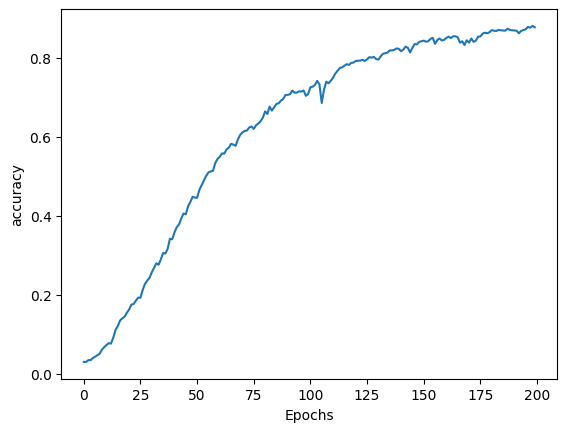

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate new lyrics!

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 18ms/step
im feeling chills me to do it as good as new was for you hearts with the fate evening front evening evening front velvet new do new life life life life life life life life life life life life life life cassandra me am think weave eyes truth truth kind life life life life life think life life life life life think life life life life life life have life have life life life life have life have life life life me life me life life have here have did life life life life have life life life life life life life cassandra
